In [1]:
import plyvel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm

from pyquery import PyQuery

from IPython.display import Markdown, display

def md(text):
    display(Markdown(text))

In [2]:
db = plyvel.DB("events.leveldb.db")

In [3]:
TYPES = {
    "content-edit": (" hat eine neue Version von ", " erstellt"),
    "content-associate": (" hat ", " assoziiert - "),
    "content-delete": (" hat ", " entfernt - "),
    "content-connect": (" hat ", " verknüpft - "),
    "content-update": (" hat ", " aktualisiert - "),
    "content-move": (" hat ", " verschoben - "),
    "content-archive": (" hat ", " archiviert - "),
    "content-recreated": (" hat ", " wiederhergestellt"),
    "content-create": (" hat ", " erstellt"),
    "review-approved": (" hat ", " ausgecheckt"),
    "review-disapproved": (" hat ", " abgelehnt"),
    "term-create": (" hat den Elter des Begriffs ", " geändert"),
    "comment": (" hat ", " kommentiert"),
    "template-notfound": ("Es wurde kein template für "),
    "license-change": (" hat die Lizenz von ", " geändert - "),
}

def convert(event):
    event = PyQuery(event.decode("utf-8"))
    event_text = event.text()
    
    event_timestamp = np.datetime64(event("abbr").text())
    event_type = None
    
    for k, v in TYPES.items():
        if all([x in event_text for x in v]):
            event_type = k
            break
        
    if not event_type:
        raise ValueError("TYPE NOT FOUND: " + event_text)
    
    if event_type != "template-notfound":
        event_author = event("a")[0].text
    else:
        event_author = None
        
    event_base_type = event_type.split("-")[0]
    
    return (event_timestamp, event_author, event_base_type, event_type)
    
data = [convert(e) for (_, e) in db.iterator(start=b"events-html", stop=b"events-html\xff")]
data.sort(key=lambda x: x[0])
data = pd.DataFrame(data, columns=["time", "author", "event_base", "event"])
data.index = data["time"]

In [4]:
data["event"] = data["event"].astype("category")
data["event_base"] = data["event_base"].astype("category")

In [5]:
data_no_legacy = data[data["author"] != "Legacy"]
data_edit = data_no_legacy[data_no_legacy["event"] == "content-edit"]

## Verlauf Anzahl aller Events pro Woche

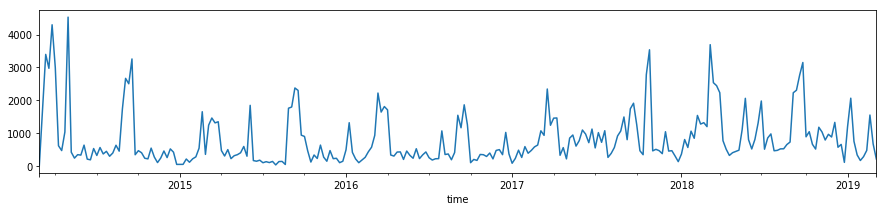

In [6]:
md("## Verlauf Anzahl aller Events pro Woche")
data_no_legacy.resample("W")["author"].count().plot(figsize=(15,3))

In [7]:
md("## Übersicht aller Events")
data_no_legacy["author"].describe()

## Übersicht aller Events

count     211185
unique       896
top       Renate
freq       12857
Name: author, dtype: object

## Verteilung der verschiedenen Arten von Events

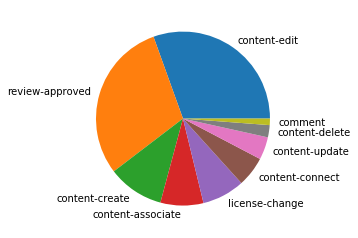

content-edit          63364
review-approved       62064
content-create        21687
content-associate     16574
license-change        16439
content-connect       11644
content-update         8762
content-delete         4707
comment                2494
content-move           1898
term-create             591
content-archive         424
template-notfound       397
review-disapproved      332
content-recreated       205
Name: event, dtype: int64

In [8]:
md("## Verteilung der verschiedenen Arten von Events")
data_no_legacy["event"].value_counts().head(9).plot(kind="pie")
plt.ylabel("")
plt.show()
data_no_legacy["event"].value_counts()

## Anzahl Events pro Jahr

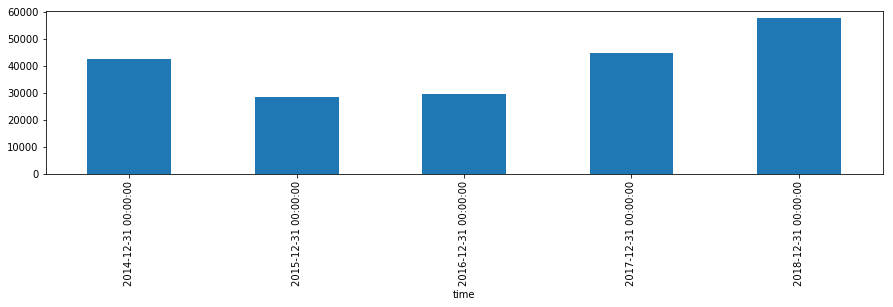

In [9]:
md("## Anzahl Events pro Jahr")
data_no_legacy.resample("Y")["author"].count()[:-1].plot(figsize=(15,3), kind="bar")

## Trends in der Anzahl der Events

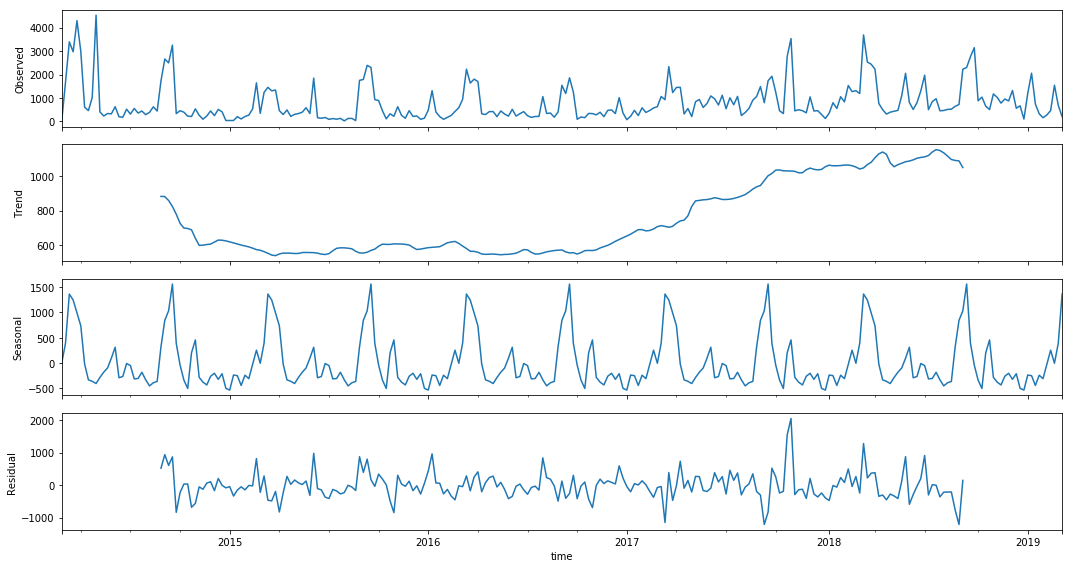

In [10]:
plt.rcParams["figure.figsize"] = (15,8)
dec = sm.tsa.seasonal_decompose(data_no_legacy.resample("W").count()["time"], model="additive")
md("## Trends in der Anzahl der Events")
dec.plot()
plt.show()

## Monatlicher Verlauf der verschiedenen Events (sortiert nach Typ)

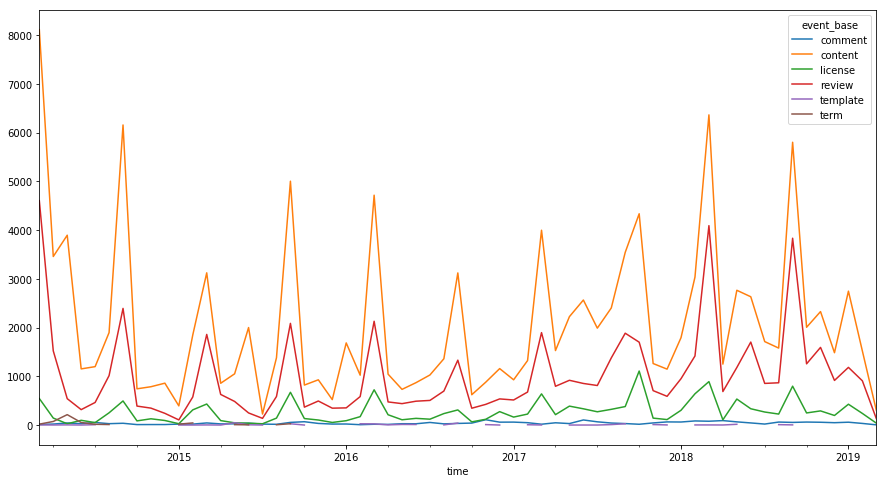

In [11]:
md("## Monatlicher Verlauf der verschiedenen Events (sortiert nach Typ)")
data_no_legacy.resample("M")["event_base"].value_counts().unstack().plot()

In [12]:
md("## 20 Top-Autorinnen (Alle-Events)")
data_no_legacy.groupby("author").count()["event"].sort_values(ascending=False).head(20)

## 20 Top-Autorinnen (Alle-Events)

author
Renate        12857
Nish           9691
chdieter       7155
Simon          6208
metzgaria      5773
kazuki         4934
Knorrke        4616
Kati_L         4468
Rebi           3890
Jonathan       3847
LeaFa          3567
Katha26        3543
Hannes         3402
Lena09         3260
Tinsaye        3217
tobi_serlo     3178
NiCi           3129
wolfgang       2664
Marvin         2559
Karin          2533
Name: event, dtype: int64

In [13]:
md("## 20 Top-Autorinnen (Nur Bearbeitungen)")
data_edit.groupby("author").count()["event"].sort_values(ascending=False).head(20)

## 20 Top-Autorinnen (Nur Bearbeitungen)

author
chdieter         2472
Nish             2313
Simon            1955
Renate           1792
Jonathan         1388
Kati_L           1363
metzgaria        1345
kazuki           1181
Knorrke          1107
LeaFa            1072
Lena09            933
Rebi              910
Tinsaye           894
adrian_wagner     874
tobi_serlo        849
Katha26           848
Niggo             810
haberlm           804
Karin             789
Manuel_Voigt      747
Name: event, dtype: int64

## Verlauf wöchentliche Anzahl Bearbeitungen

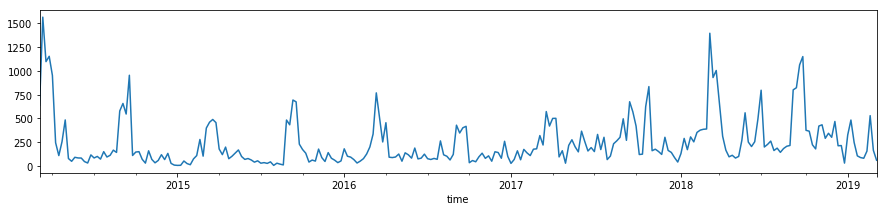

In [14]:
md("## Verlauf wöchentliche Anzahl Bearbeitungen")
data_edit.resample("W")["author"].count().plot(figsize=(15,3))

## Trend wöchentliche Bearbeitungen

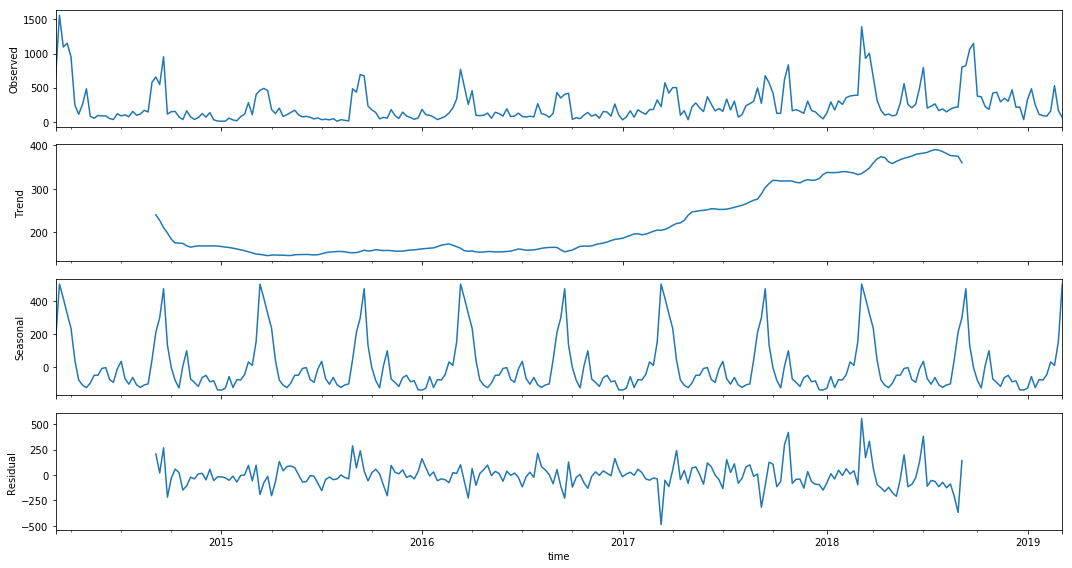

In [15]:
plt.rcParams["figure.figsize"] = (15,8)
dec = sm.tsa.seasonal_decompose(data_edit.resample("W").count()["time"], model="additive")
md("## Trend wöchentliche Bearbeitungen")
dec.plot()
plt.show()

In [16]:
last90 = data.truncate(before=pd.Timestamp.now() + pd.Timedelta("-90 days"))

a = last90[last90["event_base"] == "content"].groupby("author")["time"].count()

md("## Aktuelle aktive Autor*innen")
md("Anzahl: %s" % a[a > 10].count())
a[a > 10]

## Aktuelle aktive Autor*innen

Anzahl: 43

author
Alex_Lueckenhaus      25
Daniel-I             426
Daphne_s              14
Felix96               40
Greta                 23
Hendrik_Arl           11
Isabel_Domagala      328
Jojuacamole           79
Jonathan            1015
Karin                224
Karin2406             78
Kati_L               118
Knorrke               30
Kowalsky              52
Laura                 44
Leo1                  55
Maria_F              118
Martin_Gast           54
Michi_pi              11
Nish                 123
Quatematik            60
Renate                39
Ronnit                36
Schneeeule            32
Simon                 46
Simone_Heinrich      157
ThomasBrunner        138
Valentin01            31
_Wasserfall_Pia_      22
abcd                  14
botho                187
chdieter             104
darja_wlhlm           63
hernlmax             135
kathongi             123
laraamann             26
markus_janker        196
max25                 33
metzgaria             75
moritz0312        

## Verlauf aktive Autor*innen

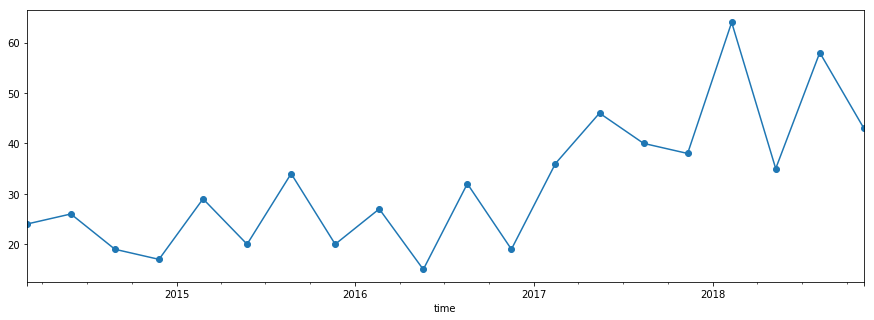

In [17]:
md("## Verlauf aktive Autor*innen")
a = data_no_legacy[data_no_legacy["event_base"] == "content"].resample("90D")["author"].value_counts()
a[a[:,:] > 10].count("time")[:-1].plot(marker="o", figsize=(15,5))

In [18]:
last90 = data.truncate(before=pd.Timestamp.now() + pd.Timedelta("-90 days"))

a = last90[last90["event_base"] == "content"].groupby("author")["time"].count()

md("## Aktuelle sehr aktive Autor*innen")
md("Anzahl: %s" % a[a > 100].count())
a[a > 100]

## Aktuelle sehr aktive Autor*innen

Anzahl: 16

author
Daniel-I            426
Isabel_Domagala     328
Jonathan           1015
Karin               224
Kati_L              118
Maria_F             118
Nish                123
Simone_Heinrich     157
ThomasBrunner       138
botho               187
chdieter            104
hernlmax            135
kathongi            123
markus_janker       196
moritz0312          555
wolfgang            106
Name: time, dtype: int64

## Verlauf sehr aktive Autor*innen

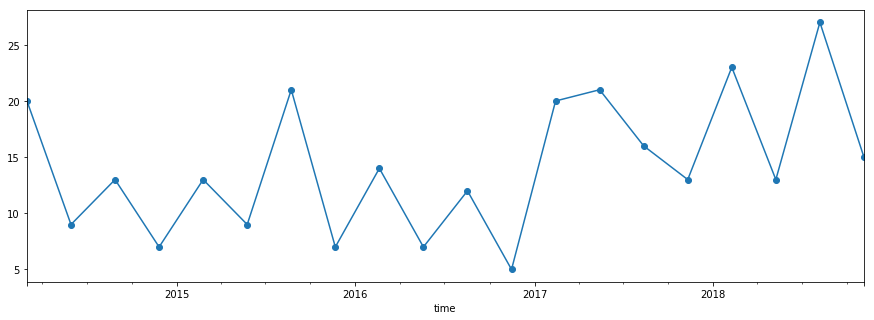

In [19]:
md("## Verlauf sehr aktive Autor*innen")
a = data_no_legacy[data_no_legacy["event_base"] == "content"].resample("90D")["author"].value_counts()
a[a[:,:] > 100].count("time")[:-1].plot(marker="o", figsize=(15,5))

In [20]:
md("## Langfristige Autor*innen")
last = data.truncate(before=pd.Timestamp.now() + pd.Timedelta("-270 days")).resample("90D")
a = last["author"].value_counts()[:-1]
p = a[a[:,:] > 10].unstack().transpose().dropna()

md("Anzahl: %s" % len(p))
p

## Langfristige Autor*innen

Anzahl: 16

time,2018-06-11 00:00:00,2018-09-09 00:00:00,2018-12-08 00:00:00
author,,,
Nish,785.0,465.0,257.0
tobi_serlo,741.0,73.0,54.0
metzgaria,681.0,475.0,100.0
Renate,675.0,372.0,93.0
Karin,630.0,352.0,387.0
wolfgang,508.0,229.0,122.0
chdieter,299.0,499.0,208.0
Simone_Heinrich,287.0,896.0,286.0
kathongi,261.0,306.0,156.0


# Reviewing

In [21]:
reviewing = data_no_legacy[data_no_legacy["event_base"] == "review"]

In [22]:
md("## 30 Top-Autorinnen (Nur Reviews)")
reviewing.groupby("author").count()["event"].sort_values(ascending=False).head(30)

## 30 Top-Autorinnen (Nur Reviews)

author
Nish             3393
chdieter         2475
Renate           2357
Simon            2057
metzgaria        1975
Jonathan         1415
Kati_L           1372
Rebi             1339
Knorrke          1224
LeaFa            1057
kazuki           1017
Tinsaye           923
Lena09            914
tobi_serlo        871
adrian_wagner     861
Katha26           844
Niggo             811
haberlm           790
Hannes            748
Manuel_Voigt      747
Karin             694
LorenzHuber       668
lotta_behrens     650
wolfgang          649
Marvin            641
NiCi              627
Lenali            621
Michi             594
Tobias            593
SebSoGa           577
Name: event, dtype: int64

In [23]:
md("## 30 Top-Autorinnen (Nur Reviews; letzte 6 Monate)")
reviewing.truncate(before=pd.Timestamp.now() + pd.Timedelta("-180days")).groupby("author").count()["event"].sort_values(ascending=False).head(30)

## 30 Top-Autorinnen (Nur Reviews; letzte 6 Monate)

author
Jonathan           1415
Viki                465
Simone_Heinrich     437
sabi21              414
SinaDE              325
Niggo               314
chdieter            309
Nish                281
ThomasBrunner       269
Karin               259
moritz0312          256
Vithusha            245
metzgaria           241
Bettina_G           217
Jojuacamole         198
Isabel_Domagala     192
DerDidaktor         184
botho               184
Kati_L              179
Daniel-I            178
kathongi            160
Stefan95            152
Renate              152
Ronnit              136
Knorrke             130
Aurelia             118
wolfgang            107
Kulla               106
LeaFa                98
markus_janker        95
Name: event, dtype: int64

In [ ]:
from itertools import count

def convert2(event):
    event = PyQuery(event.decode("utf-8"))
    event_text = event.text()
    
    event_timestamp = np.datetime64(event("abbr").text())
    event_type = None
    
    for k, v in TYPES.items():
        if all([x in event_text for x in v]):
            event_type = k
            break
        
    if not event_type:
        raise ValueError("TYPE NOT FOUND: " + event_text)
    
    links = [None, None, None]
    names = [None, None, None]
    types = ["X", "Y", "Z"]
    i = 0
    
    relation = ""
    
    for child in event.contents():
        if isinstance(child, str):
            child = child.strip()
            
            if child:
                relation += child
        else:
            if child.tag == "a":
                links[i] = child.get("href")
                names[i] = child.text
                relation += " %s " % types[i]
                
                i += 1
    
    if event_type != "template-notfound":
        event_author = event("a")[0].text
    else:
        event_author = None
        
    event_base_type = event_type.split("-")[0]
    
    return (event_timestamp, event_author, relation.strip(), event_base_type, event_type, links[0], names[0], links[1], names[1], links[2], names[2])

convert2(next(db.iterator(start=b"events-html", stop=b"events-html\xff"))[1])

data2 = [convert2(e) for (_, e) in db.iterator(start=b"events-html", stop=b"events-html\xff")]
data2.sort(key=lambda x: x[0])
data2 = pd.DataFrame(data2, columns=["time", "author", "relation", "event_base", "event", "link_X", "value_X", "link_Y", "value_Y", "link_Z", "value_Z"])
data2.index = data2["time"]
data2.to_csv("serlo-events.csv")